In [288]:
import os
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision.models as models
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [ ]:
image_folder = '/Users/rahul/Downloads/deepfashion1_data/images'
image_files = os.listdir(image_folder)
# images = [Image.open(os.path.join(image_folder, file)) for file in image_files]

In [253]:
# Select a smaller subset
num_samples = 40000
selected_images = image_files[:40000]

In [255]:
import json
description_path = '/Users/rahul/Downloads/deepfashion1_data/captions.json'
with open(description_path, 'r') as f:
    descriptions = json.load(f)

selected_descriptions = {img: descriptions[img] for img in selected_images if img in descriptions}

In [256]:
# selected_descriptions

In [ ]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts images to PyTorch tensors and scales pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])    # ImageNet std
])

# Lists to hold processed images and their captions
processed_images = []
image_captions = []

# Load and preprocess images
for img_name in selected_images:
    if img_name in selected_descriptions:
        img_path = os.path.join(image_folder, img_name)
        try:
            # Open the image and convert it to RGB (in case it's not)
            image = Image.open(img_path).convert('RGB')
            # Apply the transformations
            processed_image = transform(image)
            processed_images.append(processed_image)
            # Get the corresponding caption
            caption = selected_descriptions[img_name]
            image_captions.append(caption)
        except Exception as e:
            print(f"Error processing {img_name}: {e}")

In [260]:
assert isinstance(processed_images[0], torch.Tensor), "Processed images are not tensors!"

In [ ]:
print(f"First processed image shape: {processed_images[0].shape}")  # Check tensor shape
print(f"First caption: {image_captions[0]}")  # Should be text or tokenized caption
print(type(processed_images))  # Should be <class 'list'>
print(type(image_captions))    # Should be <class 'list'>

First processed image shape: torch.Size([3, 256, 256])
First caption: The female is wearing a long-sleeve shirt with solid color patterns. The shirt is with cotton fabric and its neckline is v-shape. The trousers the female wears is of long length. The trousers are with denim fabric and pure color patterns. This person also wears an outer clothing, with cotton fabric and stripe patterns. The lady is wearing a belt. There is an accessory on her wrist.


In [ ]:
class FashionDataset(Dataset):
    def __init__(self, image_tensors, captions, tokenizer, max_len=100):
        self.image_tensors = image_tensors
        self.captions = captions
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):
        image = self.image_tensors[idx]  # Already preprocessed tensor
        caption = self.captions[idx]
        # Tokenize caption
        encoded_caption = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "image": image,
            "input_ids": encoded_caption["input_ids"].squeeze(0),
            "attention_mask": encoded_caption["attention_mask"].squeeze(0)
        }

In [ ]:
# Assuming `image_paths` contains paths to images and `captions` has corresponding captions
train_image_paths, val_image_paths, train_captions, val_captions = train_test_split(
    processed_images, image_captions, test_size=0.2, random_state=42
)

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
val_dataset = FashionDataset(
    val_image_paths,
    val_captions,
    tokenizer=tokenizer,
    max_len=100
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,  # Adjust as needed
    shuffle=False,  # No need to shuffle validation data
    num_workers=0  # Adjust based on your setup
)

train_dataset = FashionDataset(
    train_image_paths,
    train_captions,
    tokenizer=tokenizer,
    max_len=100
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,  # Adjust as needed
    shuffle=False,  # No need to shuffle validation data
    num_workers=0  # Adjust based on your setup
)

In [270]:
sample = val_dataset[0]
print("Sample keys:", sample.keys())
print("Image shape:", sample["image"].shape)  # Should be [3, 224, 224]
print("Input IDs shape:", sample["input_ids"].shape)  # Should be [max_len]
print("Attention Mask shape:", sample["attention_mask"].shape)

Sample keys: dict_keys(['image', 'input_ids', 'attention_mask'])
Image shape: torch.Size([3, 256, 256])
Input IDs shape: torch.Size([50])
Attention Mask shape: torch.Size([50])


In [ ]:
# Fetch a batch of data
batch = next(iter(train_dataloader))
print('Image batch shape:', batch['image'].shape)
print('Input IDs batch shape:', batch['input_ids'].shape)
print('Attention mask batch shape:', batch['attention_mask'].shape)

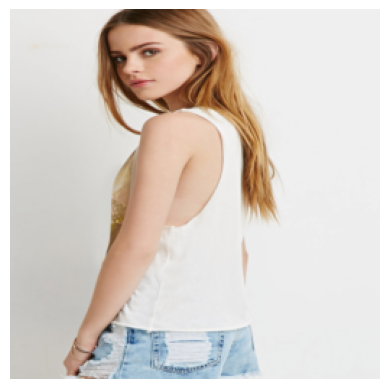

Caption: the upper clothing has no sleeves, cotton fabric and graphic patterns. there is an accessory on her wrist.


In [274]:
# Optionally, visualize an image and its caption
def imshow(img_tensor):
    img = img_tensor.numpy()
    img = img.transpose((1, 2, 0))
    # Un-normalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display the first image in the batch
imshow(batch['image'][2])

# Decode the first caption in the batch
decoded_caption = tokenizer.decode(batch['input_ids'][2], skip_special_tokens=True)
print('Caption:', decoded_caption)

In [275]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Load pre-trained ResNet50 model
        resnet = models.resnet50(pretrained=True)
        # Remove the last fully connected layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # Add a fully connected layer
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        # Initialize the fully connected layer weights
        nn.init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0)
    
    def forward(self, images):
        # Extract feature vectors
        with torch.no_grad():  # Freeze the encoder
            features = self.resnet(images)
        features = features.view(features.size(0), -1)  # Flatten
        features = self.fc(features)
        return features

In [276]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        # Embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        # Linear layer to project LSTM outputs to vocabulary space
        self.linear = nn.Linear(hidden_size, vocab_size)

        # New linear layer to project image features to hidden size
        self.fc = nn.Linear(embed_size, hidden_size)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        self.init_weights()

    def init_weights(self):
        # Initialize weights
        nn.init.xavier_uniform_(self.embed.weight)
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        self.linear.bias.data.fill_(0)
        self.fc.bias.data.fill_(0)

    def forward(self, features, captions):
        # Embed captions
        embeddings = self.embed(captions)  # (batch_size, seq_length, embed_size)

        # Project image features to hidden size
        features_proj = self.fc(features)  # (batch_size, hidden_size)

        # Initialize LSTM hidden state with projected features
        h0 = features_proj.unsqueeze(0).repeat(self.num_layers, 1, 1)  # (num_layers, batch_size, hidden_size)
        c0 = torch.zeros(self.num_layers, features.size(0), self.hidden_size).to(features.device)

        # Pass embeddings through LSTM
        hiddens, _ = self.lstm(embeddings, (h0, c0))  # hiddens: (batch_size, seq_length, hidden_size)

        # Apply dropout
        outputs = self.dropout(hiddens)

        # Generate predictions
        outputs = self.linear(outputs)  # outputs: (batch_size, seq_length, vocab_size)

        return outputs


In [278]:
embed_size = 256  # Size of the embeddings
hidden_size = 512  # Size of LSTM hidden states
vocab_size = len(tokenizer)  # Vocabulary size
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [279]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(30522, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=30522, bias=True)
  (fc): Linear(in_features=256, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
learning_rate = 1e-3
params = list(decoder.parameters()) + list(encoder.fc.parameters())
optimizer = optim.Adam(params, lr=learning_rate)

In [287]:
num_epochs = 2

for epoch in range(num_epochs):
    # Training Phase
    encoder.train()
    decoder.train()
    for batch_idx, batch in enumerate(train_dataloader):
        images = batch['image'].to(device)
        captions = batch['input_ids'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions[:, :-1])

        # Compute loss
        loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Validation Phase
    encoder.eval()
    decoder.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_images = val_batch['image'].to(device)
            val_captions = val_batch['input_ids'].to(device)

            # Forward pass
            val_features = encoder(val_images)
            val_outputs = decoder(val_features, val_captions[:, :-1])

            # Compute validation loss
            val_loss += criterion(
                val_outputs.reshape(-1, vocab_size), val_captions[:, 1:].reshape(-1)
            ).item()

    val_loss /= len(val_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")


Epoch [1/5], Step [0/1930], Loss: 3.8667
Epoch [1/5], Step [100/1930], Loss: 3.4247
Epoch [1/5], Step [200/1930], Loss: 2.7783
Epoch [1/5], Step [300/1930], Loss: 1.9857
Epoch [1/5], Step [400/1930], Loss: 1.7005
Epoch [1/5], Step [500/1930], Loss: 1.2152
Epoch [1/5], Step [600/1930], Loss: 0.9893
Epoch [1/5], Step [700/1930], Loss: 0.9636
Epoch [1/5], Step [800/1930], Loss: 0.8405
Epoch [1/5], Step [900/1930], Loss: 0.7263
Epoch [1/5], Step [1000/1930], Loss: 0.7618
Epoch [1/5], Step [1100/1930], Loss: 0.6983
Epoch [1/5], Step [1200/1930], Loss: 0.6327
Epoch [1/5], Step [1300/1930], Loss: 0.6340
Epoch [1/5], Step [1400/1930], Loss: 0.6441
Epoch [1/5], Step [1500/1930], Loss: 0.6087
Epoch [1/5], Step [1600/1930], Loss: 0.6238
Epoch [1/5], Step [1700/1930], Loss: 0.6152
Epoch [1/5], Step [1800/1930], Loss: 0.6013
Epoch [1/5], Step [1900/1930], Loss: 0.5735
Epoch [1/5], Validation Loss: 0.5419
Epoch [2/5], Step [0/1930], Loss: 0.5754
Epoch [2/5], Step [100/1930], Loss: 0.5668
Epoch [2/5]

In [290]:
# After completing all epochs
torch.save(encoder.state_dict(), 'encoder_final.pth')
torch.save(decoder.state_dict(), 'decoder_final.pth')
print("Models have been saved successfully.")


Models have been saved successfully.


In [289]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    for batch in val_dataloader:
        images = batch['image'].to(device)
        captions = batch['input_ids'].to(device)

        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions[:, :-1])

        # Compute loss
        val_loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))

        print(f"Validation Loss: {val_loss.item():.4f}")

Validation Loss: 0.4224
Validation Loss: 0.3979
Validation Loss: 0.4597
Validation Loss: 0.4464
Validation Loss: 0.4455
Validation Loss: 0.4259
Validation Loss: 0.4231
Validation Loss: 0.4477
Validation Loss: 0.4285
Validation Loss: 0.4654
Validation Loss: 0.4451
Validation Loss: 0.4613
Validation Loss: 0.4700
Validation Loss: 0.4530
Validation Loss: 0.4403
Validation Loss: 0.4216
Validation Loss: 0.4136
Validation Loss: 0.4489
Validation Loss: 0.3729
Validation Loss: 0.4376
Validation Loss: 0.4268
Validation Loss: 0.4257
Validation Loss: 0.4479
Validation Loss: 0.4515
Validation Loss: 0.4084
Validation Loss: 0.4582
Validation Loss: 0.4567
Validation Loss: 0.4621
Validation Loss: 0.4164
Validation Loss: 0.4600
Validation Loss: 0.4380
Validation Loss: 0.4243
Validation Loss: 0.4503
Validation Loss: 0.4411
Validation Loss: 0.4886
Validation Loss: 0.5085
Validation Loss: 0.4023
Validation Loss: 0.4300
Validation Loss: 0.4303
Validation Loss: 0.4210
Validation Loss: 0.4411
Validation Loss:

In [291]:
def generate_caption(image_path, encoder, decoder, tokenizer, max_length=20):
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
        
        # Generate caption
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            features = encoder(image)

            # Start decoding
            inputs = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
            caption = []
            for _ in range(max_length):
                outputs = decoder(features, inputs)
                _, predicted = outputs[:, -1, :].max(1)  # Get the index of the max log-probability
                predicted_id = predicted.item()

                if predicted_id == tokenizer.sep_token_id:  # Stop if <SEP> token is generated
                    break

                caption.append(tokenizer.decode(predicted_id))
                inputs = torch.cat([inputs, predicted.unsqueeze(0)], dim=1)

        return " ".join(caption)

    except Exception as e:
        return f"Error generating caption: {e}"

# Example usage
image_path = "/Users/rahul/Downloads/deepfashion1_data/images/WOMEN-Shorts-id_00000103-04_1_front.jpg"
caption = generate_caption(image_path, encoder, decoder, tokenizer)
print("Generated Caption:", caption)

Generated Caption: the upper clothing has short sleeves , cotton fabric and solid color patterns . the neck ##line of it is


In [294]:
from nltk.translate.bleu_score import sentence_bleu

def evaluate_model(dataloader, encoder, decoder, tokenizer):
    encoder.eval()
    decoder.eval()
    total_bleu_score = 0
    count = 0
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            actual_captions = batch['input_ids'].to(device)
            for i in range(images.size(0)):
                image = images[i]
                actual_caption = tokenizer.decode(actual_captions[i], skip_special_tokens=True)
                generated_caption = generate_caption(image, encoder, decoder, tokenizer)
                reference = [actual_caption.split()]
                candidate = generated_caption.split()
                bleu_score = sentence_bleu(reference, candidate)
                total_bleu_score += bleu_score
                count += 1
    avg_bleu_score = total_bleu_score / count
    print(f'Average BLEU Score: {avg_bleu_score:.4f}')
